<center><img src="header.png" width = "800"/></center>

### <b> InSAR Coherent Change Detection over Aleppo, Syria (April 17-29, 2016)
    
<b><i> Corey Scher<sup>1</sup>
<i>Jamon Van Den Hoek<sup>2</sup>
    
<i><font size=2> 1. Department of Earth and Environmental Sciences | Graduate Center at the City University of New York
    
<i><font size=2> 2. College of Earth, Ocean, and Atmospheric Sciences | Oregon State University

<span style="font-size: 16pt"> **Part two**: bi-temporal change detection </span>

In [1]:
import os
import shapely
import rasterio
import rioxarray
import shapely.wkt
import numpy as np
import xarray as xr
import folium
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
#Set paths to insar data, figures directory, and results

insar_path = r'C:\Tarig\Edinburgh\Masters Courses\Dissertation\ARSET INSAR\arset-arset\porefluid-arset-5c9fb3a\code\AlGineina'
fig_dir = r'C:\Tarig\Edinburgh\Masters Courses\Dissertation\ARSET INSAR\arset-arset\porefluid-arset-5c9fb3a\code\AlGineina\Figs'
res_dir = r'C:\Tarig\Edinburgh\Masters Courses\Dissertation\ARSET INSAR\arset-arset\porefluid-arset-5c9fb3a\code\AlGineina\Res'

In [3]:
# Set the filepath to each coherence image
pre_event = os.path.join(insar_path, 
                         'S1AA_20230331T042216_20230412T042216_VVP012_INT40_G_ueF_F922',
                         'S1AA_20230331T042216_20230412T042216_VVP012_INT40_G_ueF_F922_corr.tif')

event = os.path.join(insar_path, 
                         'S1AA_20230412T042216_20230611T042219_VVP060_INT40_G_ueF_4C79',
                         'S1AA_20230412T042216_20230611T042219_VVP060_INT40_G_ueF_4C79_corr.tif')

In [4]:
#Open each coherence image

pre = xr.open_dataset(pre_event, engine="rasterio")
post = xr.open_dataset(event, engine="rasterio")

In [5]:
#Define and area of interest as WKT over Aleppo, Syria

aoi = shapely.wkt.loads("POLYGON ((22.466651 13.535195, 22.356762 13.436374, 22.373932 13.3796, 22.425443 13.373588, 22.505112 13.410326, 22.521595 13.476441, 22.512667 13.524514, 22.466651 13.535195))")
gs = gpd.GeoSeries(aoi, crs = 'EPSG:4326').to_crs(pre.rio.crs)

# Translate to geojson for quick addition to interactrive Folium maps
geo_j = folium.GeoJson(data=gs.to_json())

In [6]:
# Clip to our area of interest using our geoseries gs

pre = pre.rio.clip(gs)
post = post.rio.clip(gs)

In [7]:
#Align the rasters and retrieve each aligned element
aligned = xr.align(pre, post)

#Retrieve that aligned rasters
pre = aligned[0]
post = aligned[1]

In [8]:
# Calculate the change in coherence as a percentage relative to the pre-conflict coherence
dif = (post - pre)/pre


In [9]:
#Make a mask for areas with a pre-event coherence under 0.9
stable_pixel_mask = pre >= 0.9

# Mask out areas with low pre-event coherence and any changes in coherence greater than zero
dif = dif.where((stable_pixel_mask != 0) & (dif <= 0))

#Save the raster
dif.band_data.rio.to_raster(os.path.join(res_dir, 'april_12_June_11_2023_Geneina.tif'))

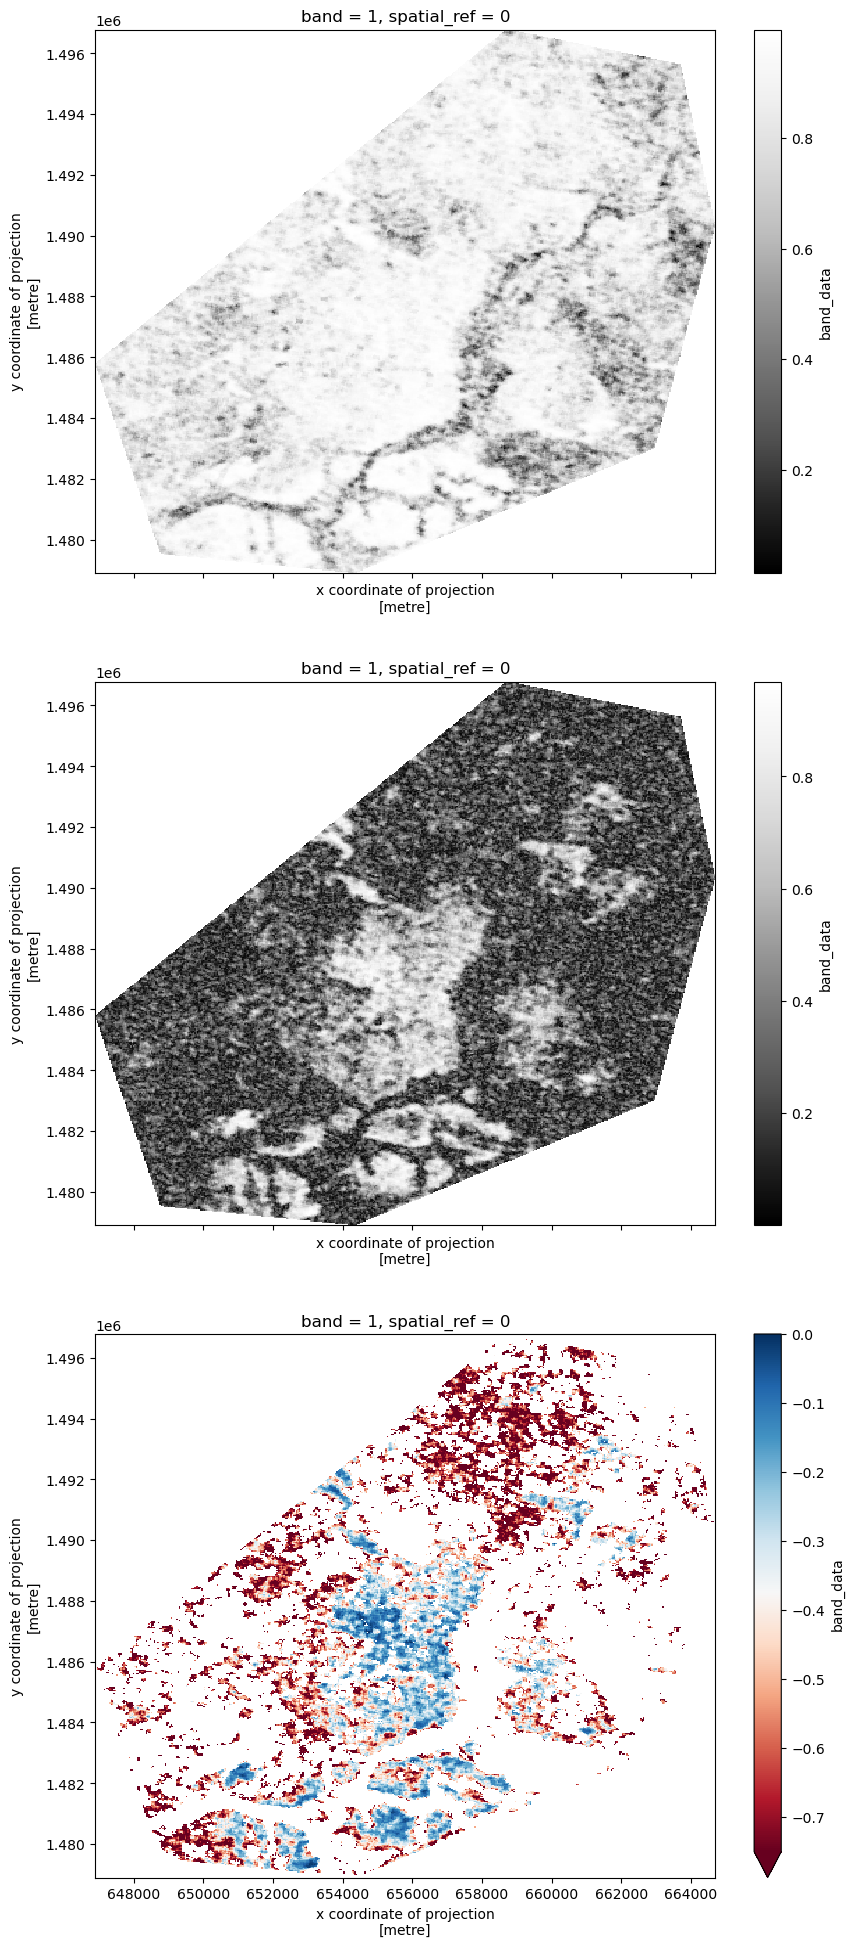

In [10]:
fig, ax = plt.subplots(3,1, figsize=(10,24), sharex=True)

mask = pre['band_data'] < 0.8

pre['band_data'].plot(cmap='Greys_r', ax = ax[0])
post['band_data'].plot(cmap='Greys_r', ax = ax[1])

dif.where(pre > 0.9)['band_data'].plot(cmap='RdBu', ax = ax[2], vmin = -.75, vmax = 0)

# dif.plot(cmap='RdBu', ax = ax[2], vmin = -.75, vmax = 0)
# dif_mask.where(dif_mask ==0).plot(cmap='RdBu', ax = ax[2], vmin = -.75, vmax = 0)

# for a in ax:
#     a.set_xlim(37.08, 37.22)
#     a.set_ylim(36.13, 36.26)
    
# plt.savefig(os.path.join(fig_dir, 'example_aleppo.png'), dpi=300, facecolor='white')

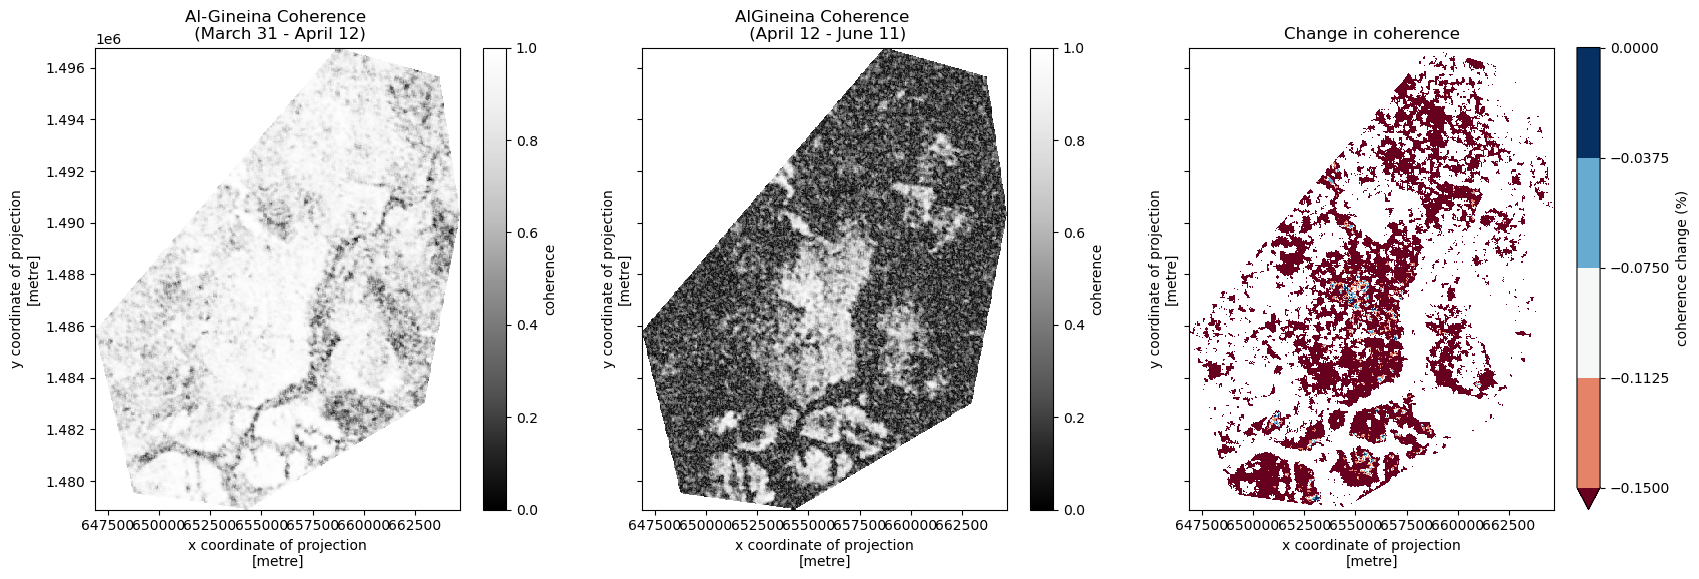

In [11]:
#Plot all of the data!

fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey = True)

im1 =  pre.band_data.plot(ax = ax[0], cmap='Greys_r', vmin = 0, vmax = 1, label = 'test')
im2 = post.band_data.plot(ax = ax[1], cmap='Greys_r', vmin = 0, vmax = 1)
im3 = dif.band_data.plot(ax = ax[2], vmin = -.15, vmax = 0, levels = 5, cmap = 'RdBu')

ax[0].set_title('Al-Gineina Coherence \n (March 31 - April 12)')
ax[1].set_title('AlGineina Coherence \n (April 12 - June 11)')
ax[2].set_title('Change in coherence')

im1.colorbar.set_label('coherence')
im2.colorbar.set_label('coherence')
im3.colorbar.set_label('coherence change (%)')

plt.savefig(os.path.join(fig_dir, 'Al-Geneina_example.png'), dpi=300, facecolor='white')